# Visualization for Delegation Based Lock

In [1]:
@time using DataFrames, CSV
using AlgebraOfGraphics, CairoMakie, Query
using AlgebraOfGraphics: density

CairoMakie.activate!(type = "svg")


bench = @time CSV.read("output/output.csv", DataFrame)


  1.788226 seconds (1.51 M allocations: 91.165 MiB, 2.85% gc time, 0.36% compilation time)


  1.880657 seconds (798.83 k allocations: 53.983 MiB, 3.18% gc time, 99.77% compilation time: 74% of which was recompilation)


Row,Id,CpuId,ThreadNum,CpuNum,LoopCount,NumAcquire,HoldTime,CombineTime,Locktype
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64?,String
1,0,0,2,32,187728526,243397,2445,16408538280,Flat Combining (SkipList)
2,1,1,2,32,552806965,239101,7183,13359516600,Flat Combining (SkipList)
3,0,0,2,32,184831867,240972,2421,29915654790,Flat Combining
4,1,1,2,32,557214360,240971,7240,missing,Flat Combining
5,0,0,2,32,370708271,481642,4838,20113799040,Flat Combining Fair
6,1,1,2,32,281597317,121937,3663,7105796130,Flat Combining Fair
7,0,0,2,32,343826329,478047,4803,13192347030,Flat Combining Fair With Combiner Slice
8,1,1,2,32,262572263,121220,3642,12940274910,Flat Combining Fair With Combiner Slice
9,0,0,2,32,219871766,313222,3147,missing,SpinLock


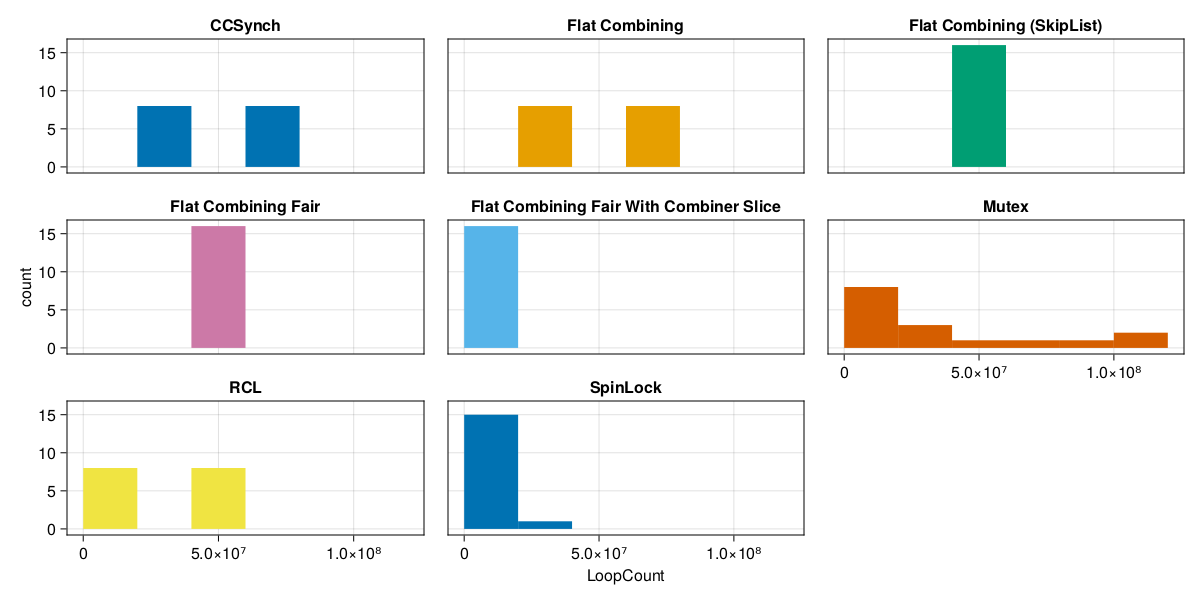

In [55]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

fig = Figure(resolution = (1200, 600))

loop_comparison = ((@chain bench begin
        Tidier.@filter(ThreadNum == 16)
end) |> data) * mapping(:LoopCount, layout = :Locktype, color = :Locktype) * histogram()
    
# savefig(loop_comparison, "graphs/loop_comparison.svg")
draw!(fig, loop_comparison)

save("graphs/loop_comparison.svg", fig)

fig

In [12]:
import Pkg; Pkg.add("Tidier")

    Updating registry at `C:\Users\hongt\.julia\registries\General.toml`


   Resolving package versions...

   Installed Chain ─── v0.5.0


   Installed Cleaner ─ v0.5.0


   Installed Tidier ── v0.7.6


    Updating `C:\Users\hongt\.julia\environments\v1.9\Project.toml`
  [f0413319] + Tidier v0.7.6
    Updating `C:\Users\hongt\.julia\environments\v1.9\Manifest.toml`


  [8be319e6] + Chain v0.5.0
⌅ [caabdcdb] + Cleaner v0.5.0
  [f0413319] + Tidier v0.7.6
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`


Precompiling 

project...


  ✓ Chain


  ✓ Cleaner


  ✓ Tidier


  3 dependencies successfully precompiled in 12 seconds. 289 already precompiled.


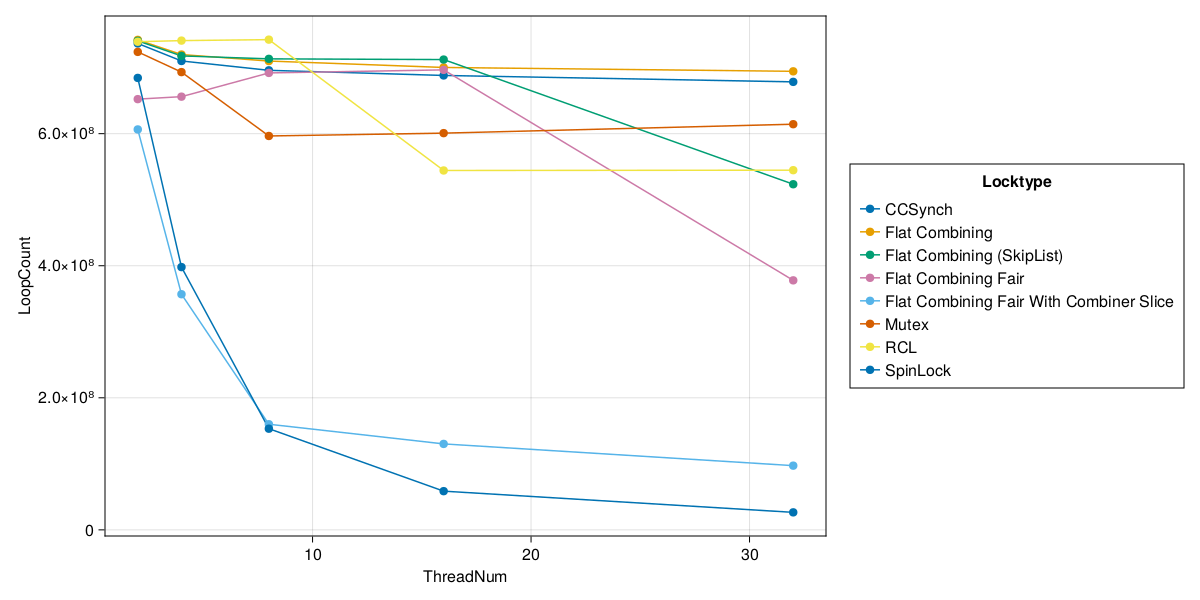

In [75]:
using Tidier
using AlgebraOfGraphics, CairoMakie

bench2 = @chain bench begin
    @group_by(Locktype, ThreadNum)
    @summarise(LoopCount = sum(LoopCount))
    @ungroup
end

plt = data(bench2) * mapping(:ThreadNum, :LoopCount, color = :Locktype) * (visual(Lines) + visual(Scatter))

fig = draw(plt, figure = (resolution=(1200,600),))

save("graphs/loop_comparison.svg", fig)

fig

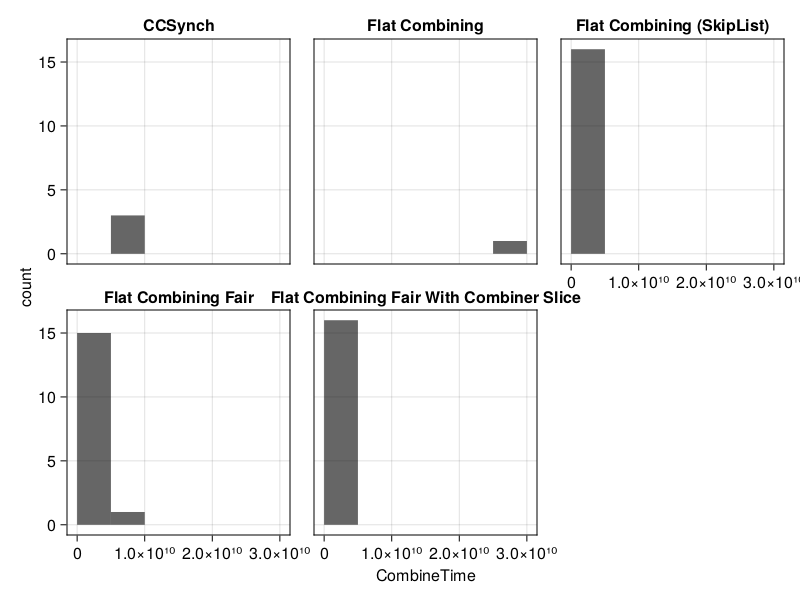

In [47]:
using DataFrames, Tidier, AlgebraOfGraphics, CairoMakie

bench_32thread = @chain dropmissing(bench) begin
    Tidier.@filter(ThreadNum == 16)
end

plt = data(bench_32thread) * mapping(:CombineTime, layout = :Locktype) * histogram(bins = 10)

draw(plt)